In [1]:
import warnings, gc
import numpy as np 
import pandas as pd
import matplotlib.colors
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from datetime import datetime, timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
import matplotlib.pyplot as plt

import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from codecs import raw_unicode_escape_decode




c:\Users\Wian\anaconda3\envs\MasterEnv\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Business Cycles

In [3]:
# Read in and construct the initial dataset.

def createDataset(csv):
    temp_ds = pd.read_csv(csv)
    temp_ds.date = pd.to_datetime(temp_ds.date, format="%Y/%m/%d")
    temp_ds = temp_ds.set_index('date')
    print(temp_ds.shape)
    return temp_ds

# Define folder path of source data
folder_path = "C:/Users/Wian/Desktop/Economic Data/"
#folder_path = "C:/Users/wianC/Desktop/NMRQL/Economic Data/"

# Read in description files
annual_desc = pd.read_csv(folder_path + 'annually_description_file.csv')
month_desc = pd.read_csv(folder_path + 'monthly_description_file.csv')
quarterly_desc = pd.read_csv(folder_path + 'quarterly_description_file.csv')

# Read in data files
annual_data = createDataset(folder_path + 'us_economics_annually.csv')
quarterly_data = createDataset(folder_path + 'us_economics_quarterly.csv')
monthly_data = createDataset(folder_path + 'us_economics_monthly.csv')

# Concatenate all data together (with an outer join)
concat_data = pd.concat([monthly_data, quarterly_data, annual_data], axis = 1, join='outer')

# Check that column ids (descriptions references) do not overlap between the different datasets we concatennated.
if len(concat_data.columns.unique()) < len(concat_data.columns): print("Duplicated columns present in data!")

# Check for any categorical data - The datasets are all float, hinting that there is none... Still need to verify though.
print("Dataframe unique dtypes: ", np.unique(list(concat_data.dtypes)))


# Perform resampling as well as inter- and extrapolation on the dataset.
temp_ds = concat_data.resample(rule='Q', label='right').mean().interpolate('linear').ffill()


# Let's have a threshold that removes variables that do not have enough data.
# If threshold is set to 10% (0.1) then variables with more than 10% NaN values are dropped from the dataset.
def thresholdData(data_ds, threshold):

    temp_ds = data_ds.copy()
    count = 0
    for col in temp_ds.columns:
        if temp_ds[col].isna().sum()/len(temp_ds[col]) > threshold:
            temp_ds.drop(col, axis = 1, inplace=True)
            count = count + 1
    print("Dropped" , count)
    print("Remaining: ", len(temp_ds.columns))

    return temp_ds.dropna(axis = 0)

# Create new dataset based on threshold value
threshold = 0.01
raw_ds = thresholdData(temp_ds, threshold)

# Create description dataset based on new threshold data dataset
all_desc = pd.concat((month_desc, quarterly_desc, annual_desc))
temp_list = list()
for match in raw_ds.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
raw_desc = pd.DataFrame(np.reshape(temp_list, (len(raw_ds.columns),2)), columns=all_desc.columns)


(62, 174)
(250, 442)
(751, 429)
Dataframe unique dtypes:  [dtype('float64')]
Dropped 651
Remaining:  394


In [ ]:
# A medium page describes four business cycles:
# Reflation, Recovery, Overheat and Stagflation.

# Reflation — Financials, Consumer Staples, Healthcare, and Consumer Discretionary;
# Recovery — Telecom, Tech, Basic Materials, and Consumer Discretionary;
# Overheat —Industrials, Tech, Basic Materials, and Energy;
# Stagflation — Utilities, Consumer Staples, Healthcare, and Energy.

# 
#  # https://medium.com/@richardhwlin/how-does-investment-clock-work-c7d8fbbeb7bd

In [6]:
def SearchForMatches(searchWords, desc_df):

    temp_dict = dict()
    for i in range(len(desc_df)):
        temp_dict[i] = np.array(desc_df['description'])[i]

    temp_array = temp_dict.values()
    for word in searchWords:
        matches = [match for match in temp_array if word in match]
        print(word)
        print("There are ", len(matches), " matches for ", word, ":")

    print()
    print('Description/s:')
    print()
    targets = list()
    temp_ids = list()
    for match in matches:
        print(match)
        temp_ids.append(list(desc_df.loc[lambda desc_df: desc_df['description'] == match]['series_id'])[0])

    return temp_ids

In [142]:
searchWords = ['Consumer Price Index']
temp_ids = SearchForMatches(searchWords, raw_desc)

CPI_data = pd.DataFrame(data = raw_ds[[str(id) for id in temp_ids if str(id) in raw_ds.columns]])


# Create description dataset based on new threshold data dataset
temp_list = list()
for match in CPI_data.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
CPI_desc = pd.DataFrame(np.reshape(temp_list, (len(CPI_data.columns),2)), columns=all_desc.columns)


index = 0
print()
print("Choosing signal", CPI_desc.iloc[index].series_id)
print(CPI_desc.iloc[index].description)
CPI = CPI_data.iloc[:,index].pct_change(4).dropna()*100
CPI

Consumer Price Index
There are  9  matches for  Consumer Price Index :

Description/s:

United States: Consumer Price Index CPI [Consumer Price Index, All items:  United States]
United States: Consumer Price Index CPI [US: CPI: All Urban Consumers (CPI-U-82/84): All Items]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, Apparel (1982-1984), SA - United States [US: CPI-U-82/84: sa: Apparel]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, All Items (1982-1984), SA - United States [US: CPI: All Urban Consumers (CPI-U-82/84): sa: All Items]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, Medical Care (1982-1984), SA - United States [US: CPI-U-82/84: sa: Medical Care (MC)]
United States: Prices, Consumer Price Index, CPI: All Urban Consumers, Transportation (1982-1984), SA - United States [US: CPI-U-82/84: sa: Transport]
United States: Consumer Price Index, Average [US: CPI: All Urban Consumers (CPI-U-82/84): All Items]
Un

date
1961-06-30    0.935270
1961-09-30    1.277327
1961-12-31    0.658376
1962-03-31    0.853450
1962-06-30    1.316752
                ...   
2021-09-30    5.338855
2021-12-31    6.691792
2022-03-31    7.965751
2022-06-30    8.639210
2022-09-30    6.925039
Freq: Q-DEC, Name: 43717, Length: 246, dtype: float64

In [106]:
searchWords = ['Gross Domestic Product']

#searchWords = ['United States: GDP - Real (USD) [US: Gross Domestic Product (GDP): 2012p: sa]']

temp_ids = SearchForMatches(searchWords, raw_desc)

GDP_data = pd.DataFrame(data = raw_ds[[str(id) for id in temp_ids if str(id) in raw_ds.columns]])


# Create description dataset based on new threshold data dataset
temp_list = list()
for match in GDP_data.columns:
    temp_list.append(all_desc[all_desc['series_id'] == int(match)])
GDP_desc = pd.DataFrame(np.reshape(temp_list, (len(GDP_data.columns),2)), columns=all_desc.columns)

index = 9
print()
print("Choosing signal", GDP_desc.iloc[index].series_id)
print(GDP_desc.iloc[index].description)
GDP = GDP_data.iloc[:,index].pct_change(4).dropna()*100

#index = 8
#print(GDP_desc.iloc[index].description)
#print(GDP_desc.iloc[index].series_id)
#GDP = GDP_data.iloc[:,index]
GDP


Gross Domestic Product
There are  25  matches for  Gross Domestic Product :

Description/s:

United States: GDP (USD) [US: Gross Domestic Product (GDP): sa]
United States: GDP [US: Gross Domestic Product (GDP): sa]
United States: GDP Annual Growth Rate [US: Gross Domestic Product (GDP): sa: PCTCHG_1]
United States: GDP Annual Growth Rate [US: Gross Domestic Product (GDP): sa: PCTCHG_2]
United States: GDP Constant Prices [US: Gross Domestic Product (GDP): 2012p: sa]
United States: GDP Growth Annualized [US: Gross Domestic Product (GDP): sa: PCTCHG_3]
United States: GDP Growth Rate [US: Gross Domestic Product (GDP): sa: PCTCHG_4]
United States: GDP - Nominal [US: Gross Domestic Product (GDP): sa]
United States: GDP - Real (Growth - YoY%) [US: Gross Domestic Product (GDP): 2012p: sa: PCTCHG]
United States: GDP - Real [US: Gross Domestic Product (GDP): 2012p: sa]
United States: GDP - Real (Growth - YoY%) - Forecast [US: Gross Domestic Product (GDP): 2012p: sa: PCTCHG: Forecast original ser

date
1961-06-30    1.564455
1961-09-30    3.009921
1961-12-31    6.395530
1962-03-31    7.567276
1962-06-30    6.727690
                ...   
2021-09-30    4.946556
2021-12-31    5.533484
2022-03-31    3.527892
2022-06-30    1.617963
2022-09-30    1.041070
Freq: Q-DEC, Name: 45999, Length: 246, dtype: float64

<AxesSubplot:xlabel='date'>

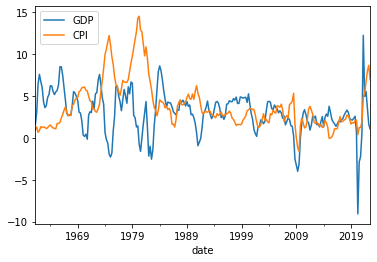

In [168]:
signals = pd.DataFrame((GDP, CPI)).transpose().rename(columns = {'45999' : 'GDP', '43717' : 'CPI'})
signals.plot()

In [187]:
def InvestmentClockFixed(x,cuts={'GDP':2.5,'CPI':3}):

    x_ = x.copy().assign(Growth=None,Inflation=None,Theme=None)
    
    # define high and low growth
    x_.loc[x['GDP']<=cuts['GDP'],'Growth'] = 'low'
    x_.loc[x['GDP']>cuts['GDP'],'Growth'] = 'high'
   
    # define high and low inflation  
    x_.loc[x['CPI']<=cuts['CPI'],'Inflation'] = 'low'
    x_.loc[x['CPI']>cuts['CPI'],'Inflation'] = 'high'
   
    # define investment clock phases
    x_.loc[(x_.Growth=='low')&(x_.Inflation=='low'),'Theme'] = 'Reflection'
    x_.loc[(x_.Growth=='high')&(x_.Inflation=='low'),'Theme'] = 'Recovery'
    x_.loc[(x_.Growth=='high')&(x_.Inflation=='high'),'Theme'] = 'Overheat'
    x_.loc[(x_.Growth=='low')&(x_.Inflation=='high'),'Theme'] = 'Stagflation'

    return x_.dropna()

themes = InvestmentClockFixed(signals,cuts={'GDP':2.5,'CPI':3})
themes

,GDP,CPI,Growth,Inflation,Theme
date,,,,,
1961-06-30,1.564455,0.935270,low,low,Reflection
1961-09-30,3.009921,1.277327,high,low,Recovery
1961-12-31,6.395530,0.658376,high,low,Recovery
1962-03-31,7.567276,0.853450,high,low,Recovery
1962-06-30,6.727690,1.316752,high,low,Recovery
...,...,...,...,...,...
2021-09-30,4.946556,5.338855,high,high,Overheat
2021-12-31,5.533484,6.691792,high,high,Overheat
2022-03-31,3.527892,7.965751,high,high,Overheat


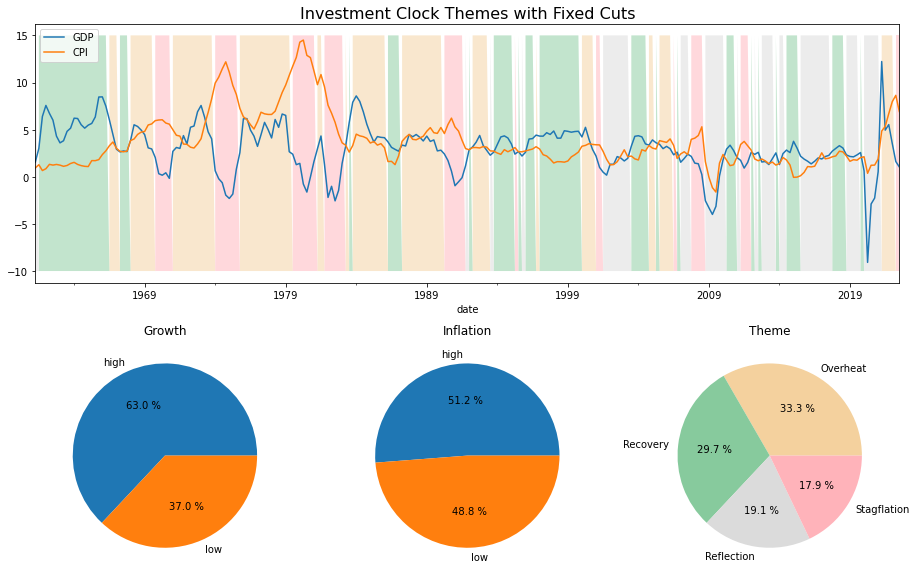

In [188]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Investment Clock Themes with Fixed Cuts',fontsize=16)
ax1 = fig.add_axes((0,0.5,1,0.45))
ax2 = fig.add_axes((0,0,0.3,0.4))
ax3 = fig.add_axes((0.35,0,0.3,0.4))
ax4 = fig.add_axes((0.7,0,0.3,0.4))
y_lim = (-10,15)
colors = dict(
  Overheat='#f4d19e',
  Recovery='#87ca9d',
  Reflection='#dbdbdb',
  Stagflation='#ffb3ba'
) 
p1 = themes[['GDP','CPI']].plot(ax=ax1)
for t in ['Overheat','Recovery','Reflection','Stagflation']:
   ax1.fill_between(
      themes.index, y_lim[0],y_lim[1], 
      where=(themes.Theme==t),
      interpolate = True,
      facecolor=colors[t], 
      alpha = 0.5
   )
growth_counts=themes.Growth.value_counts()
ax2.pie(growth_counts,autopct='%.1f %%',
        labels=growth_counts.index)
ax2.set_title('Growth')
inflation_counts=themes.Inflation.value_counts()
ax3.pie(inflation_counts,autopct='%.1f %%',
        labels=inflation_counts.index)
ax3.set_title('Inflation')
theme_counts=themes.Theme.value_counts().sort_index(ascending=True)
ax4.pie(theme_counts,autopct='%.1f %%',
        labels=theme_counts.index,colors=colors.values())
ax4.set_title('Theme')
plt.show()